## Plotting Notebook
#### for visalizing binned prevalence of malaria from hm sims and cuts

## Import Block

In [1]:
import itertools
import os, re
import sqlite3
from collections import OrderedDict

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from scipy.special import gammaln

from collections import OrderedDict
import itertools
from calibtool.analyzers.Helpers import \
    convert_to_counts, age_from_birth_cohort, season_from_time, aggregate_on_index

## Specify experiment to analyze

In [2]:
exp_id = '446b6e07-fc07-ea11-a2c3-c4346bcb1551'

## Load in experiment analyzer_results

In [3]:
results_df = pd.read_csv(os.path.join(exp_id,'plotting_analyzer_results.csv'))
results_df.rename(columns ={'age_bin':'Age Bin','density_bin': 'PfPR Bin','season':'Season','value':'sim_proportion'},inplace=True)
results_df['log10 PfPR Bin'] = np.log10(results_df['PfPR Bin'])

print(results_df['PfPR Bin'].unique())

print(results_df.head())

[     50     500 2000000]
   Unnamed: 0  sample                                sim_id Season  Age Bin  \
0           0       1  bf2f690d-fc07-ea11-a2c3-c4346bcb1551    DC2        1   
1           0       1  bf2f690d-fc07-ea11-a2c3-c4346bcb1551    DC2        4   
2           0       1  bf2f690d-fc07-ea11-a2c3-c4346bcb1551    DC2        8   
3           0       1  bf2f690d-fc07-ea11-a2c3-c4346bcb1551    DC2       18   
4           0       1  bf2f690d-fc07-ea11-a2c3-c4346bcb1551    DC2       28   

   PfPR Bin  sim_proportion  log10 PfPR Bin  
0        50        0.405276         1.69897  
1        50        0.087067         1.69897  
2        50        0.025342         1.69897  
3        50        0.003146         1.69897  
4        50        0.000000         1.69897  


## Read reference data

In [4]:
def grouped_df(df, pfprdict, index, column_keep, column_del):
    """
    Recut dataframe to recategorize data into desired age and parasitemia bins

    Args:
        df: Dataframe to be rebinned
        pfprdict: Dictionary mapping postive counts per slide view (http://garkiproject.nd.edu/demographic-parasitological-surveys.html)
                to density of parasites/gametocytes per uL
        index: Multi index into which 'df' is rebinned
        column_keep: Column (e.g. parasitemia) to keep
        column_del: Column (e.g. gametocytemia) to delete
    """
    dftemp = df.copy()
    del dftemp[column_del]

    dftemp['PfPR Bin'] = df[column_keep]
    dftemp = aggregate_on_index(dftemp, index)

    dfGrouped = dftemp.groupby(['Season', 'Age Bin', 'PfPR Bin'])

    dftemp = dfGrouped[column_keep].count()
    dftemp = dftemp.unstack().fillna(0).stack()
    dftemp = dftemp.rename(column_keep).reset_index()
    dftemp['PfPR Bin'] = [pfprdict[p] for p in dftemp['PfPR Bin']]

    dftemp = dftemp.set_index(['Season', 'Age Bin', 'PfPR Bin'])

    return dftemp

In [5]:
df = pd.read_csv(os.path.join('..','reference data','Garki_df.csv'))
self = pd.DataFrame()
self.metadata =  {
        'density_bins': [0, 50, 200, 500, 2000000],  # (, 0] (0, 50] ... (50000, ]
        'density_bin_edges':['0', '50', '200', '500'],
        'age_bins': [1, 4, 8, 18, 28, 43, 125],  # (, 5] (5, 15] (15, ],
        'age_bin_labels':['<1', '1-4', '4-8', '8-18', '18-28', '28-43', '>43'],
        'seasons': ['DC2', 'DH2', 'W2'],
        'seasons_by_month': {
            'Apr': 'DH2',
            'June/Aug': 'W2',
            'Dec/Jan': 'DC2'
        },
        'village': 'Rafin Marke'
    }

df = df.loc[df['Village']==self.metadata['village']]
pfprBinsDensity = self.metadata['density_bins']
uL_per_field = 0.5 / 200.0  # from Garki PDF - page 111 - 0.5 uL per 200 views
pfprBins = 1 - np.exp(-np.asarray(pfprBinsDensity) * uL_per_field)
seasons = self.metadata['seasons']
pfprdict = dict(zip(pfprBins, pfprBinsDensity))

bins = OrderedDict([
    ('Season', self.metadata['seasons']),
    ('Age Bin', self.metadata['age_bins']),
    ('PfPR Bin', pfprBins)
])
bin_tuples = list(itertools.product(*bins.values()))
index = pd.MultiIndex.from_tuples(bin_tuples, names=bins.keys())

df = df.loc[df['Seasons'].isin(seasons)]
df = df.rename(columns={'Seasons': 'Season', 'Age': 'Age Bin'})

df2 = grouped_df(df, pfprdict, index, 'Parasitemia', 'Gametocytemia')
df3 = grouped_df(df, pfprdict, index, 'Gametocytemia', 'Parasitemia')
dfJoined = df2.join(df3).fillna(0)
dfJoined = pd.concat([dfJoined['Gametocytemia'], dfJoined['Parasitemia']])
dfJoined.name = 'Counts'
dftemp = dfJoined.reset_index()
dftemp['Channel'] = 'PfPR by Gametocytemia and Age Bin'
dftemp.loc[len(dftemp) / 2:, 'Channel'] = 'PfPR by Parasitemia and Age Bin'
dftemp = dftemp.rename(columns={'Seasons': 'Season', 'PfPR Bins': 'PfPR Bin', 'Age Bins': 'Age Bin'})
dftemp = dftemp.set_index(['Channel', 'Season', 'Age Bin', 'PfPR Bin'])

ref_data =dftemp.copy(deep = True)


ref_data['bin_pop'] = ref_data.groupby(by=['Channel', 'Season', 'Age Bin'])['Counts'].sum()
ref_data['proportion'] = ref_data['Counts'] / ref_data['bin_pop']
ref_data.reset_index(inplace=True)
ref_data = ref_data[ref_data['Channel'] == 'PfPR by Parasitemia and Age Bin']
new_ref_df = pd.DataFrame()
new_ref_df = pd.DataFrame()
for i, grouping in ref_data.groupby(by=['Channel', 'Season', 'Age Bin']):
    group_subset = pd.DataFrame()
    
    low = grouping[grouping['PfPR Bin'] == 50]
    low.proportion += grouping[grouping['PfPR Bin'] == 0]['proportion'].values[0]
    
    middle = grouping[grouping['PfPR Bin'] == 500]
    middle.proportion += grouping[grouping['PfPR Bin'] == 200]['proportion'].values[0]
    
    high = grouping[grouping['PfPR Bin'] == 2000000]
    new_ref_df = pd.concat([new_ref_df,low,middle,high])
new_ref_df.drop('Counts',axis = 1, inplace=True)   
new_ref_df['log10 PfPR Bin'] = np.log10(new_ref_df['PfPR Bin'])
print(new_ref_df.head(16))


c:\venv\malaria-ug-icemr\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  
c:\venv\malaria-ug-icemr\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


                             Channel Season Age Bin  PfPR Bin  bin_pop  \
106  PfPR by Parasitemia and Age Bin    DC2       1        50     10.0   
108  PfPR by Parasitemia and Age Bin    DC2       1       500     10.0   
109  PfPR by Parasitemia and Age Bin    DC2       1   2000000     10.0   
111  PfPR by Parasitemia and Age Bin    DC2       4        50     20.0   
113  PfPR by Parasitemia and Age Bin    DC2       4       500     20.0   
114  PfPR by Parasitemia and Age Bin    DC2       4   2000000     20.0   
116  PfPR by Parasitemia and Age Bin    DC2       8        50     44.0   
118  PfPR by Parasitemia and Age Bin    DC2       8       500     44.0   
119  PfPR by Parasitemia and Age Bin    DC2       8   2000000     44.0   
121  PfPR by Parasitemia and Age Bin    DC2      18        50     50.0   
123  PfPR by Parasitemia and Age Bin    DC2      18       500     50.0   
124  PfPR by Parasitemia and Age Bin    DC2      18   2000000     50.0   
126  PfPR by Parasitemia and Age Bin  

## Compare sim and ref df

In [6]:
# print(results_df.head())
# print(ref_df.head())
new_ref_df['Age Bin'] = new_ref_df['Age Bin'].astype(int)
new_ref_df['binomial error'] = np.sqrt((new_ref_df['proportion']*(1-new_ref_df['proportion']))/new_ref_df['bin_pop'])

merged_df = new_ref_df.merge(results_df)
# merged_df.sort_values(by= ['sim_id'],inplace = True)
print(merged_df.head(5))

                           Channel Season  Age Bin  PfPR Bin  bin_pop  \
0  PfPR by Parasitemia and Age Bin    DC2        1        50     10.0   
1  PfPR by Parasitemia and Age Bin    DC2        1        50     10.0   
2  PfPR by Parasitemia and Age Bin    DC2        1        50     10.0   
3  PfPR by Parasitemia and Age Bin    DC2        1        50     10.0   
4  PfPR by Parasitemia and Age Bin    DC2        1        50     10.0   

   proportion  log10 PfPR Bin  binomial error  Unnamed: 0  sample  \
0         0.5         1.69897        0.158114           0       1   
1         0.5         1.69897        0.158114           0       3   
2         0.5         1.69897        0.158114           0      84   
3         0.5         1.69897        0.158114           0       6   
4         0.5         1.69897        0.158114           0      59   

                                 sim_id  sim_proportion  
0  bf2f690d-fc07-ea11-a2c3-c4346bcb1551        0.405276  
1  c12f690d-fc07-ea11-a2c3-c43

In [7]:
season = 'W2'
wetset = merged_df[merged_df.Season == season]
wet_ref =  new_ref_df[new_ref_df.Season == season]

print(wetset['PfPR Bin'].unique())

[     50     500 2000000]


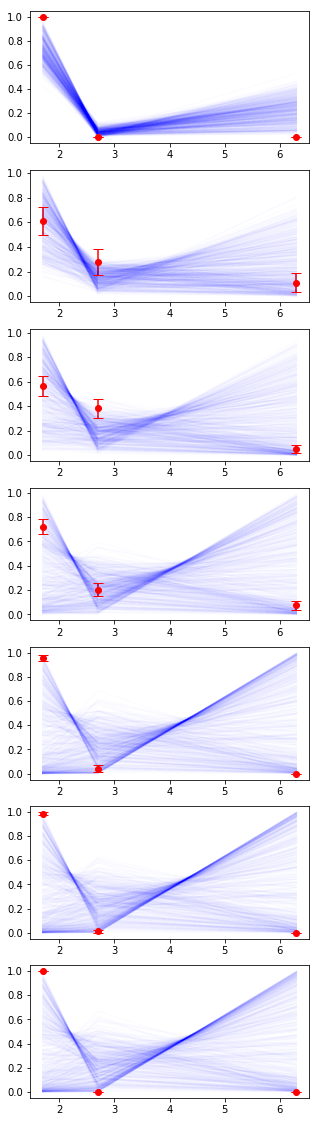

In [8]:
fig, ax = plt.subplots(nrows = len(self.metadata['age_bins']),ncols = 1,figsize = (5,20))

for i, group in wetset.groupby(by = ['sim_id','Age Bin']):
    age = i[1]
    age_bin_index, = np.where(self.metadata['age_bins'] == age)[0]
    ax[age_bin_index].plot(group['log10 PfPR Bin'],group['sim_proportion'],color = 'b', alpha = 0.01)
    
for j, ref_group in wet_ref.groupby(by = ['Channel','Age Bin']):
    age = j[1]
    age_bin_index, = np.where(self.metadata['age_bins'] == age)[0]
    ax[age_bin_index].errorbar(ref_group['log10 PfPR Bin'],ref_group['proportion'],yerr =ref_group['binomial error'] ,fmt='o', capsize = 5,color = 'r', alpha = 1)

#     ax_index, = np.where(self.metadata['age_bins'] == j)[0]

#     print(ax_index)
village = self.metadata['village']
fig_output_path = rf'C:\Users\jorussell.INTERNAL\Dropbox (IDM)\Malaria Team Folder\projects\updated_infection_and_immunity\malaria-two-pt-oh\figures\ASTMH_2019\Garki_age_calibration\{village}\{exp_id}'
os.makedirs(fig_output_path, exist_ok = True)
plt.savefig(os.path.join(fig_output_path,f'pfpr_by_season_age_denisty_bin_lineerror_{season}.png'))
plt.savefig(os.path.join(fig_output_path,f'pfpr_by_season_age_denisty_bin_lineerror_{season}.eps'))
plt.show()

## Plot

In [9]:
# g = sns.FacetGrid(merged_df, col='Season', row='Age Bin')
# g = g.map(plt.plot, "log10 PfPR Bin", "proportion", color='r')
# g = g.map(plt.scatter, "log10 PfPR Bin", "sim_proportion", alpha = 0.02, color='b')
# fig_output_path = rf'C:\Users\jorussell.INTERNAL\Dropbox (IDM)\Malaria Team Folder\projects\updated_infection_and_immunity\malaria-two-pt-oh\figures\ASTMH_2019\Garki_age_calibration\{self.metadata.village}\{exp_id}'
# os.makedirs(fig_output_path, exist_ok = True)
# plt.savefig(os.path.join(fig_output_path,'pfpr_by_season_age_denisty_bin.png'))
# plt.savefig(os.path.join(fig_output_path,'pfpr_by_season_age_denisty_bin.eps'))